In [1]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd

In [2]:
import MDAnalysis as mda
mda.__version__

'2.7.0'

In [3]:
import nglview

In [4]:
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content

/home/pmemidi/anaconda3/envs/QCB/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [5]:
data_path = "../../data/01_raw/02_NPT/01_npt_1/"
proc_path = "../../data/02_processed/02_prod/"

sel = 'name CA'

config_file = data_path + "step5_production.gro"
rawtraj_file = data_path + "step5_production.xtc"
prctraj_file = proc_path + 'prod_1/prod_1_traj_aligned.xtc'
# already done
# rawtraj_file = data_path + "step5_production.xtc"
# prctraj_file = proc_path + 'prod_1/step5_production_aligned_lastframe.xtc'
# rec_traj = mda.Universe(config_file, rawtraj_file)
# rec_ref = mda.Universe(config_file, rawtraj_file)
# rec_ref.trajectory[-1]
# aligner = AlignTraj(rec_traj,rec_ref,select=sel,filename = prctraj_file)
# aligner.run()

config_12_file = proc_path + "prod_2_not_terminated/struct_1.tpr"
cattraj_file = proc_path + "prod_2_not_terminated/p_12_concat_al.xtc"
traj1_file = proc_path + 'prod_2_not_terminated/prod_1_nbc.xtc'
traj2_file = proc_path + 'prod_2_not_terminated/prod_2_nbc.xtc'
# already done
# rec_traj = mda.Universe(config_file, [traj1_file, traj2_file])
# rec_ref = mda.Universe(config_12_file, traj2_file)
# rec_ref.trajectory[-1]
# aligner = AlignTraj(rec_traj,rec_ref,select=sel,filename = cattraj_file)
# aligner.run()

In [6]:
rec_alignd = mda.Universe(config_file, prctraj_file)
rec_alignd_ref = mda.Universe(config_file, prctraj_file)
rec_alignd_ref.trajectory[-1]

cat_alignd = mda.Universe(config_12_file, cattraj_file)
cat_alignd_ref = mda.Universe(config_12_file, cattraj_file)
cat_alignd_ref.trajectory[-1]

/home/pmemidi/anaconda3/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


< Timestep 441 with unit cell dimensions [71.04431 71.04431 71.04431 90.      90.      90.     ] >

In [7]:
print(f"frames of traj prod_1: {rec_alignd.trajectory.n_frames}")
print(f"frames of traj prod_1 concatted with traj prod_2: {cat_alignd.trajectory.n_frames}")

frames of traj prod_1: 241
frames of traj prod_1 concatted with traj prod_2: 442


In [8]:
view = nglview.show_mdanalysis(cat_alignd)
view

NGLWidget(max_frame=441)

In [9]:
R = RMSD(rec_alignd, rec_alignd_ref, select=sel).run()
Rcat = RMSD(cat_alignd, cat_alignd_ref, select=sel).run()

Text(0, 0.5, 'rmsd')

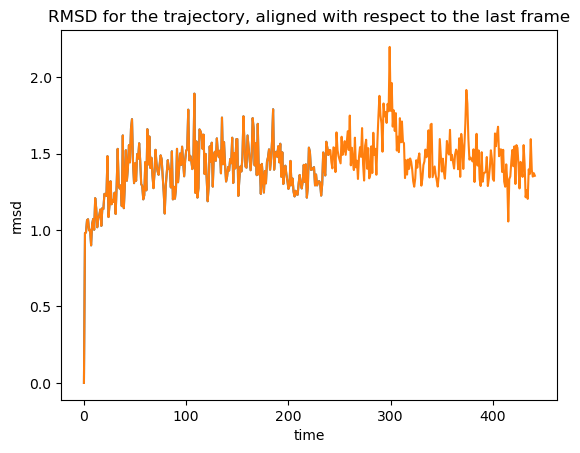

In [10]:
plt.title("RMSD for the trajectory, aligned with respect to the last frame")
plt.plot(R.results.rmsd[:, 0], R.results.rmsd[:, 2])
plt.plot(Rcat.results.rmsd[:, 0], Rcat.results.rmsd[:, 2])
plt.xlabel("time")
plt.ylabel("rmsd")

In [11]:
Rf = RMSF(rec_alignd.select_atoms(sel)).run()
Rfcat = RMSF(cat_alignd.select_atoms(sel)).run()

Text(0, 0.5, 'RMSF')

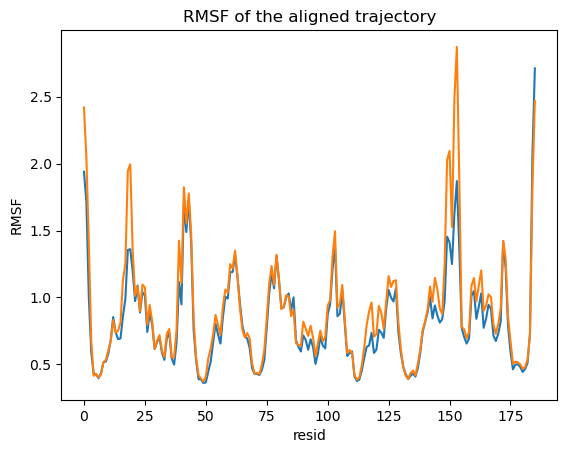

In [12]:
plt.title("RMSF of the aligned trajectory")
plt.plot(Rf.results.rmsf)
plt.plot(Rfcat.results.rmsf)
plt.xlabel("resid")
plt.ylabel("RMSF")

In [13]:
cat_pca = PCA(cat_alignd, select=sel)
cat_pca.run()

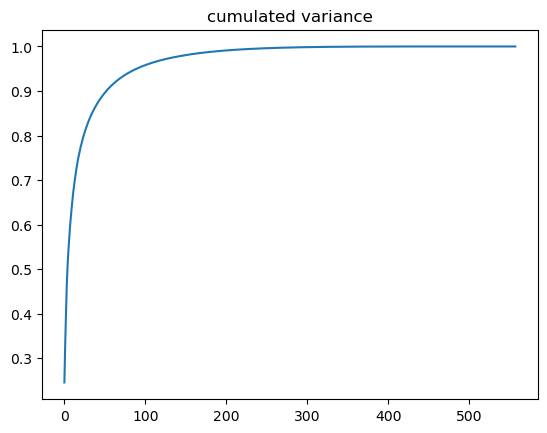

In [14]:
plt.title("cumulated variance")
plt.plot(cat_pca.results.cumulated_variance)

In [15]:
print(cat_pca.results.cumulated_variance[2])

0.40507755712608273


In [16]:
pca_space = cat_pca.transform(cat_alignd.select_atoms(sel), 2)

In [17]:
pca_data = pd.DataFrame(pca_space,columns=['first_comp','second_comp'])
pca_data["group"] = pca_data.index // 40
pca_data

,first_comp,second_comp,group
0,-0.007851,-1.135925,0
1,5.488079,-0.983398,0
2,4.735354,-1.826143,0
3,6.594894,-3.974940,0
4,0.437033,-3.147992,0
...,...,...,...
437,12.655003,-1.681039,10
438,9.445059,0.909882,10
439,7.286546,2.820195,10
440,7.715640,2.171528,11


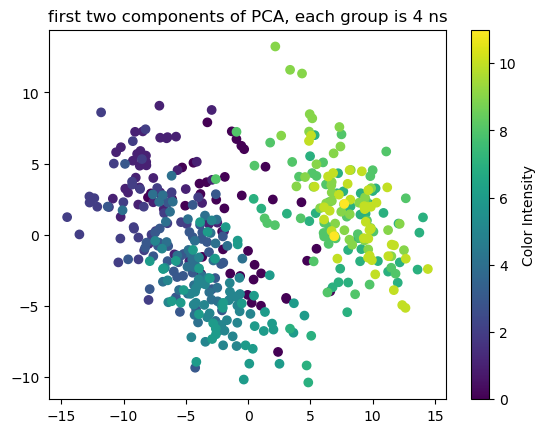

In [18]:
plt.title("first two components of PCA, each group is 4 ns")
scatter = plt.scatter(pca_data["first_comp"], pca_data["second_comp"], c= pca_data["group"])
plt.colorbar(scatter, label='Color Intensity')

In [19]:
pc1 = cat_pca.p_components[:, 0]
trans1 = pca_space[:, 0]
projected = np.outer(trans1, pc1) + cat_pca.mean.flatten()
coordinates = projected.reshape(len(trans1), -1, 3)

/home/pmemidi/anaconda3/envs/QCB/lib/python3.12/site-packages/MDAnalysis/analysis/pca.py:321: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)


In [20]:
proj1 = mda.Merge(cat_alignd.select_atoms(sel))
proj1.load_new(coordinates, order="fac")

<Universe with 186 atoms>

In [21]:
cat_alignd.select_atoms("name CA").write("traj_pca.pdb")

/home/pmemidi/anaconda3/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/pmemidi/anaconda3/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/pmemidi/anaconda3/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/pmemidi/anaconda3/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"
/home/pmemidi/anaconda3/envs/QCB/lib/python3.12/site-pack

In [22]:
view = nglview.show_mdanalysis(proj1)
view

NGLWidget(max_frame=441)

In [23]:
Rred = RMSF(proj1.select_atoms(sel)).run()

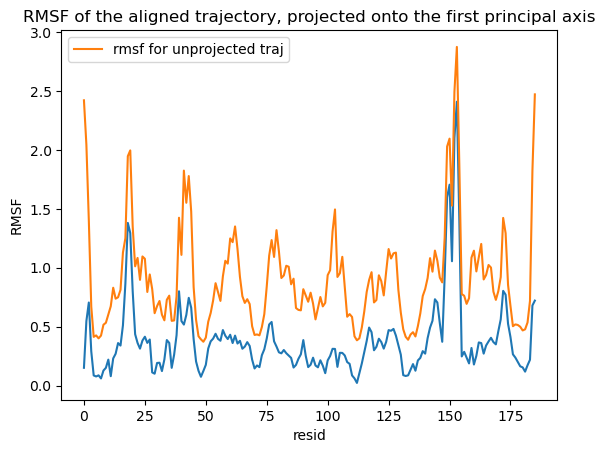

In [24]:
plt.title("RMSF of the aligned trajectory, projected onto the first principal axis")
plt.plot(Rred.results.rmsf)
plt.plot(Rfcat.results.rmsf, label = "rmsf for unprojected traj")
plt.xlabel("resid")
plt.ylabel("RMSF")
plt.legend()